In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import LinearAE, ConvAE

# Data Loading & Model Init

In [9]:
# Load MNIST
dataset = datasets.MNIST(root='./data', train=True, download=True,transform = transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# Split MNIST into train, validation, and test sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# model = LinearAE()
model = ConvAE(use_skip = True)
# L2 Loss
loss = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of trainable parameters: 12201


# Denoising Autoencoderm

In [11]:
# Run it through a single example
example = next(iter(dataloader))[0][0]
# Forward pass
output = model(example.unsqueeze(0))
print(output.shape)

torch.Size([1, 1, 28, 28])


In [12]:
# Denoising Autoencoders
noise_factor = 0 # Set it to 0 to disable noise
epochs = 5
outputs = []
losses = []

device = "mps"
model.to(device)

# Calculate total number of batches for progress bar
total_batches = epochs * len(dataloader)
# Create a single progress bar for all training steps
with tqdm(total=total_batches, desc="Training", unit="batch") as pbar:
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            noisy = images + noise_factor * torch.randn_like(images)  # Add noise
            noisy = torch.clamp(noisy, 0., 1.)  # Ensure pixel values are between 0 and 1
            output = model(noisy)
            batch_loss = loss(output, images)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            losses.append(batch_loss.item())
            epoch_loss += batch_loss.item()
            
            # Update progress bar with current loss
            pbar.set_postfix({
                'Epoch': f'{epoch+1}/{epochs}',
                'Batch': f'{batch_idx+1}/{len(dataloader)}',
                'Loss': f'{batch_loss.item():.6f}',
                'Avg Loss': f'{epoch_loss/(batch_idx+1):.6f}'
            })
            pbar.update(1)
        
        # Store output from last batch of each epoch
        outputs.append(output.cpu().detach().numpy())
        # Calculate validation loss after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_images, _ in val_dataloader:
                val_images = val_images.to(device)
                val_output = model(val_images)
                val_loss += loss(val_output, val_images).item()
        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.6f}")
        model.train()

Training:   0%|          | 0/9375 [00:00<?, ?batch/s]

Training:  20%|██        | 1893/9375 [00:19<02:43, 45.64batch/s, Epoch=2/5, Batch=19/1875, Loss=0.023302, Avg Loss=0.023514]   

Epoch 1: Validation Loss = 0.024065


Training:  40%|████      | 3772/9375 [00:38<02:16, 41.08batch/s, Epoch=3/5, Batch=23/1875, Loss=0.007728, Avg Loss=0.008469]   

Epoch 2: Validation Loss = 0.008240


Training:  60%|██████    | 5646/9375 [00:57<01:03, 58.73batch/s, Epoch=4/5, Batch=22/1875, Loss=0.004368, Avg Loss=0.004579]   

Epoch 3: Validation Loss = 0.004575


Training:  80%|████████  | 7520/9375 [01:15<00:31, 58.75batch/s, Epoch=5/5, Batch=21/1875, Loss=0.002521, Avg Loss=0.002841]   

Epoch 4: Validation Loss = 0.002841


Training: 100%|██████████| 9375/9375 [01:32<00:00, 100.95batch/s, Epoch=5/5, Batch=1875/1875, Loss=0.001961, Avg Loss=0.002320]

Epoch 5: Validation Loss = 0.001870


In [ ]:
# # save model state dict
# # torch.save(model.state_dict(), 'conv_ae_mnist.pth')
# # Load model state dict
# device = "mps"
# model.load_state_dict(torch.load('conv_ae_mnist.pth'))
# model.to(device)

RuntimeError: Error(s) in loading state_dict for LinearAE:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.6.weight", "encoder.6.bias", "encoder.8.weight", "encoder.8.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias", "decoder.6.weight", "decoder.6.bias", "decoder.8.weight", "decoder.8.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "deconv1.weight", "deconv1.bias", "deconv2.weight", "deconv2.bias", "deconv3.weight", "deconv3.bias". 

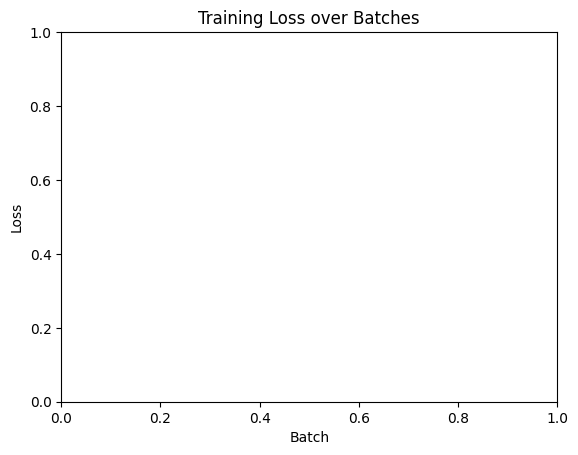

Test Loss = 0.001820


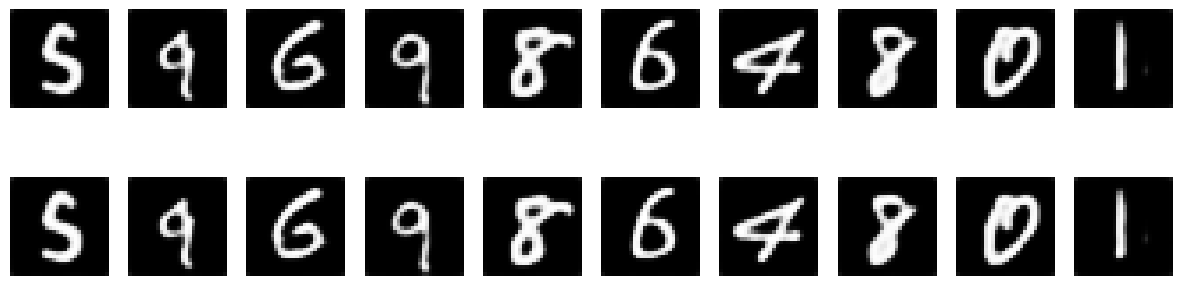

In [14]:
# plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.show()

# calculate test loss
model.eval()
test_loss = 0
with torch.no_grad():
    for test_images, _ in test_dataloader:
        test_images = test_images.to(device)
        test_output = model(test_images)
        test_loss += loss(test_output, test_images).item()
test_loss /= len(test_dataloader)
print(f"Test Loss = {test_loss:.6f}")
# Visualize some outputs
def visualize_outputs(outputs, num_images=10):
    """Visualize the outputs of the autoencoder."""
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(outputs[-1][i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(outputs[-1][i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()
visualize_outputs(outputs, num_images=10)